In [77]:
import os
import pandas as pd
from datasets import load_dataset

def get_datasets(model):
    directory_path = f"../results/0-shot-with-datasets-{model}-0.6/"

    dataset_list = []

    for filename in os.listdir(directory_path):
        if filename.endswith(".csv"):
            file_path = os.path.join(directory_path, filename)
            dataset = pd.read_csv(file_path)
            dataset_list.append((dataset, filename.split('.')[0]))
    return dataset_list

In [43]:
llama_datasets = get_datasets('llama2')
mistral_datasets = get_datasets('mistral')
gemma_datasets = get_datasets('gemma')
datasets = [(llama_datasets, 'llama2'), (mistral_datasets, 'mistral'), (gemma_datasets, 'gemma')]

In [22]:
dataset, name = llama_datasets[0]
name

'AAVE-dataset'

In [25]:
unique_indices = []
for models_predictions in datasets:
    for model_specific_dataset, name in models_predictions:
        for index, row in model_specific_dataset.iterrows():
            if ( ('positive' not in row['prediction']) & ('negative' not in row['prediction']) ) and index not in unique_indices:
                unique_indices.append(index)

In [32]:
len(unique_indices)

368

In [62]:
for models_predictions, model_name in datasets:
    for model_specific_dataset, name in models_predictions:
        shape = model_specific_dataset.shape
        model_specific_dataset.drop(outlier, inplace=True)
        print(f"Model: {model_name} Dataset: {name} Shape before: {shape} Shape After: {model_specific_dataset.shape}")

Model: llama2 Dataset: AAVE-dataset Shape before: (1987, 5) Shape After: (1984, 5)
Model: llama2 Dataset: AAVE-Filler-words-dataset Shape before: (1987, 5) Shape After: (1984, 5)
Model: llama2 Dataset: AAVE-hashtags-words-dataset Shape before: (1987, 5) Shape After: (1984, 5)
Model: llama2 Dataset: AAVE-emojis-words-dataset Shape before: (1987, 5) Shape After: (1984, 5)
Model: llama2 Dataset: AAVE-misspelling-words-dataset Shape before: (1987, 5) Shape After: (1984, 5)
Model: llama2 Dataset: AAVE-misplaced-dangling-modifiers-dataset Shape before: (1987, 5) Shape After: (1984, 5)
Model: llama2 Dataset: Final-original-dataset Shape before: (1987, 5) Shape After: (1984, 5)
Model: mistral Dataset: AAVE-Filler-words-dataset Shape before: (1987, 5) Shape After: (1984, 5)
Model: mistral Dataset: AAVE-hashtags-words-dataset Shape before: (1987, 5) Shape After: (1984, 5)
Model: mistral Dataset: AAVE-emojis-words-dataset Shape before: (1987, 5) Shape After: (1984, 5)
Model: mistral Dataset: AAVE

In [45]:
unique_indices_after = []
for models_predictions, name in datasets:
    for model_specific_dataset, name in models_predictions:
        for index, row in model_specific_dataset.iterrows():
            if ( ('positive' not in row['prediction']) & ('negative' not in row['prediction']) ) and index not in unique_indices:
                unique_indices_after.append(index)

In [46]:
len(unique_indices_after)

0

In [61]:
len(outlier)

3

In [59]:
outlier = []
for models_predictions, model_name in datasets:
    for model_specific_dataset, dataset_name in models_predictions:
        for index, row in model_specific_dataset.iterrows():
            if (row['prediction'] != 'positive' and 'positive' in row['prediction'] and 'negative' not in row['prediction']):
                row['prediction'] = 'positive'
            elif (row['prediction'] != 'negative' and 'negative' in row['prediction'] and 'positive' not in row['prediction']):
                row['prediction'] = 'negative'
            elif ('negative' in row['prediction'] and 'positive' in row['prediction']):
                outlier.append(index)

In [71]:
for models_predictions, model_name in datasets:
    if (model_name == 'mistral'):
        for model_specific_dataset, dataset_name in models_predictions:
            if (dataset_name == 'AAVE-hashtags-words-dataset'):
                print(model_specific_dataset['prediction'].value_counts())
                model_specific_dataset[model_specific_dataset['prediction'] == 'negative, negative,'].index
                model_specific_dataset.prediction.replace('negative, negative,', 'negative', inplace=True)
                print(model_specific_dataset['prediction'].value_counts())
                

prediction
negative               1353
positive                630
negative, negative,       1
Name: count, dtype: int64
prediction
negative    1354
positive     630
Name: count, dtype: int64


## Saving Filtered Datasets

In [73]:
for models_predictions, model_name in datasets:
    for model_specific_dataset, dataset_name in models_predictions:
        model_specific_dataset = model_specific_dataset[['sentence', 'sentiment', 'prediction']]
        model_specific_dataset.to_csv(f'{model_name}/{dataset_name}.csv', index=False)

## Saving Filtered Metrics

/local/home/furquanh/tmp/ipykernel_2458342/3216554928.py:25: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots()


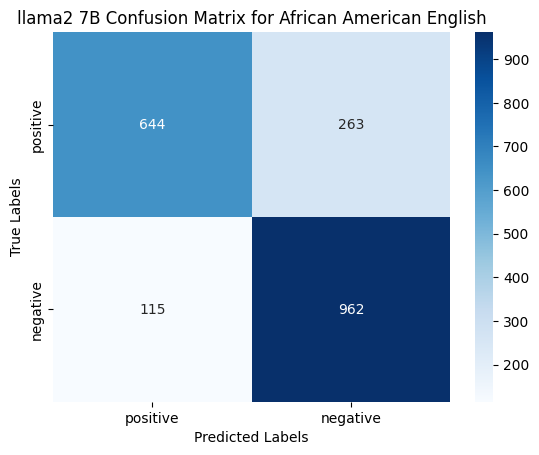

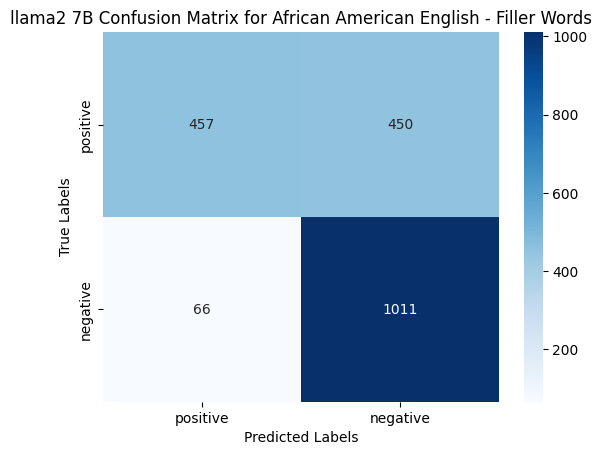

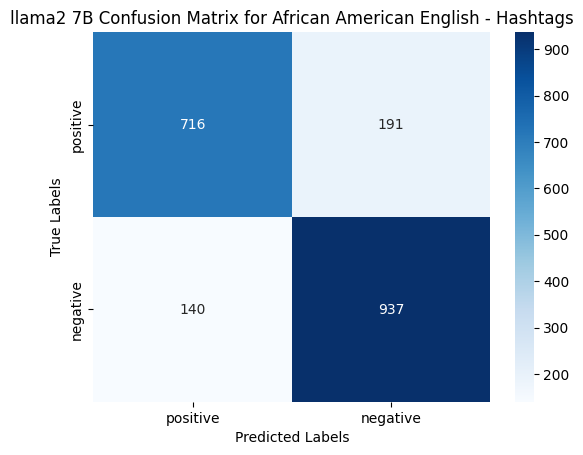

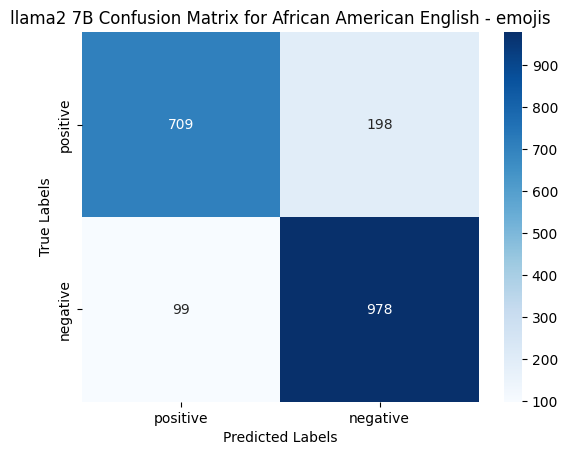

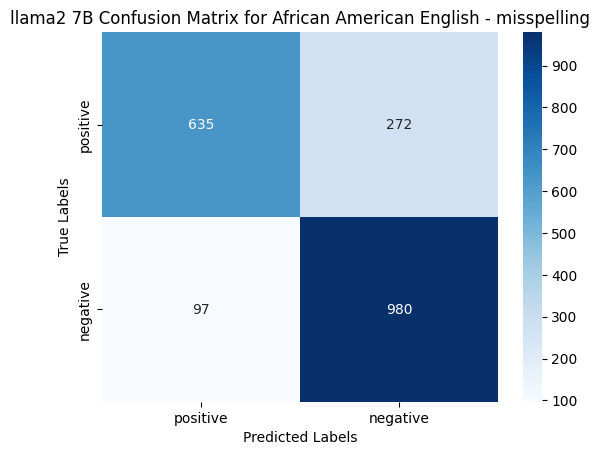

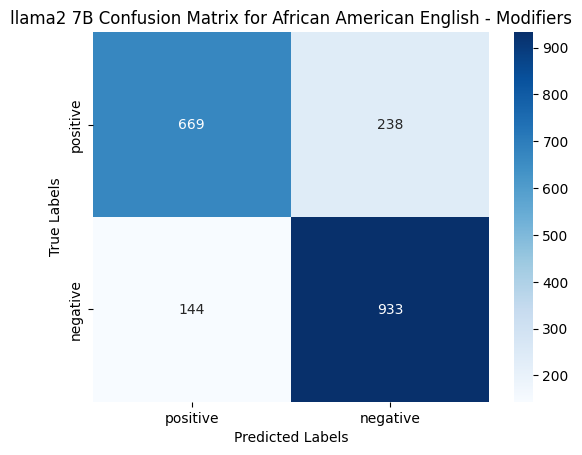

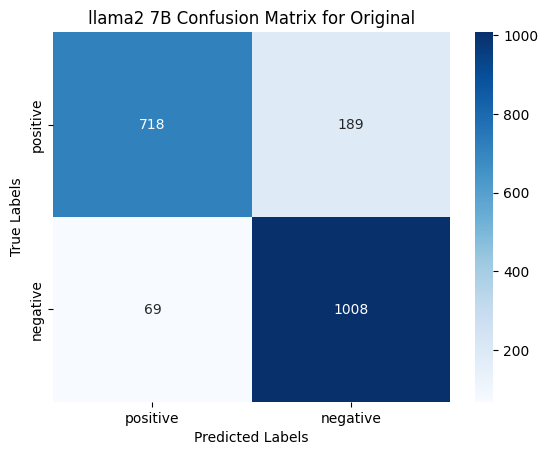

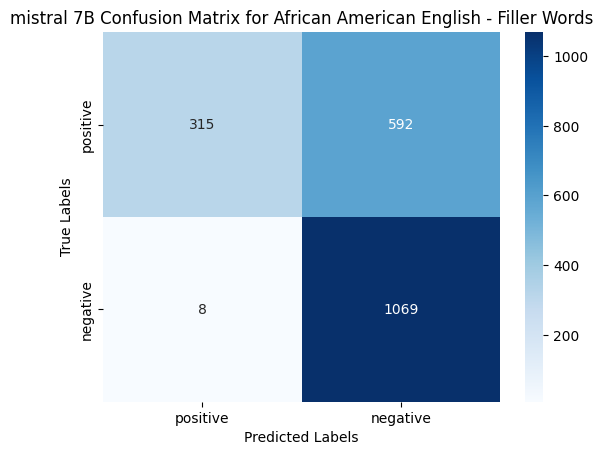

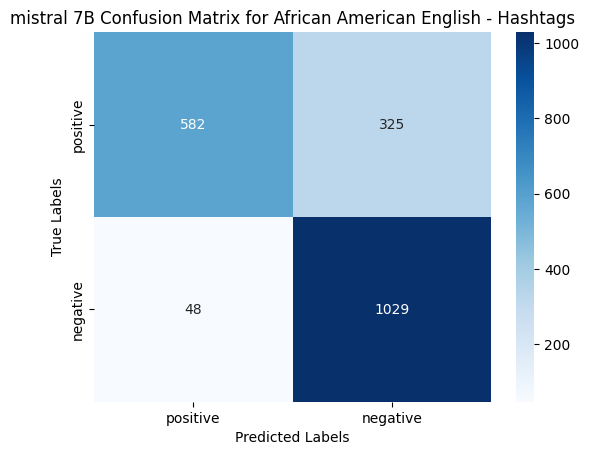

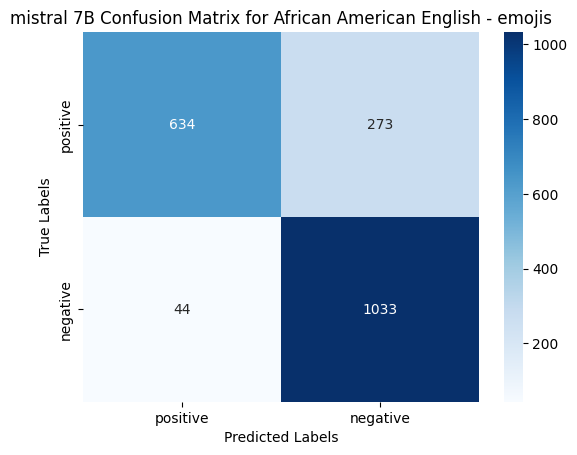

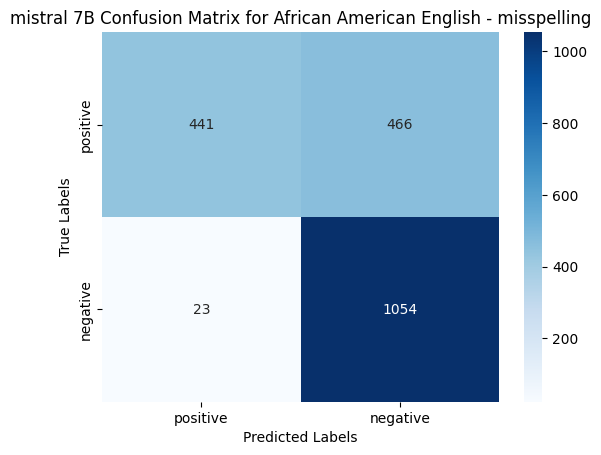

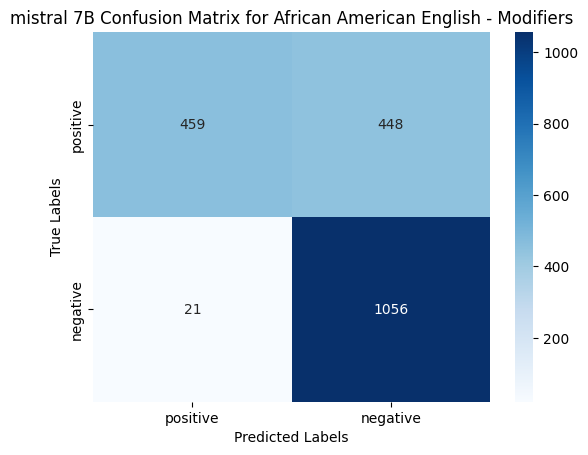

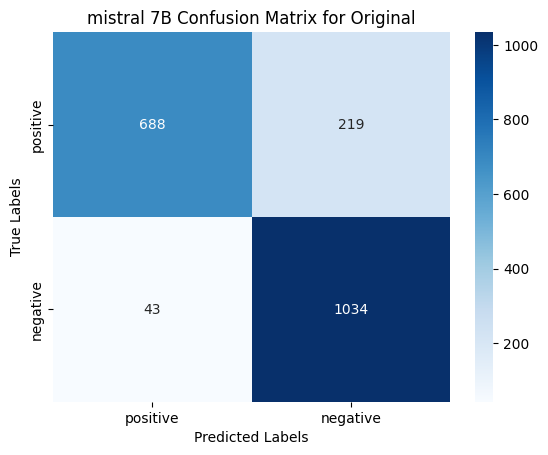

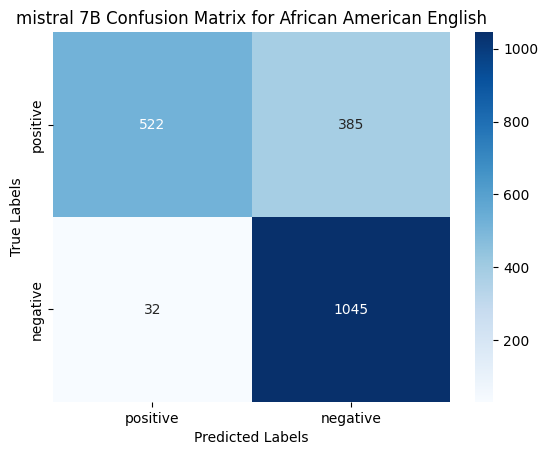

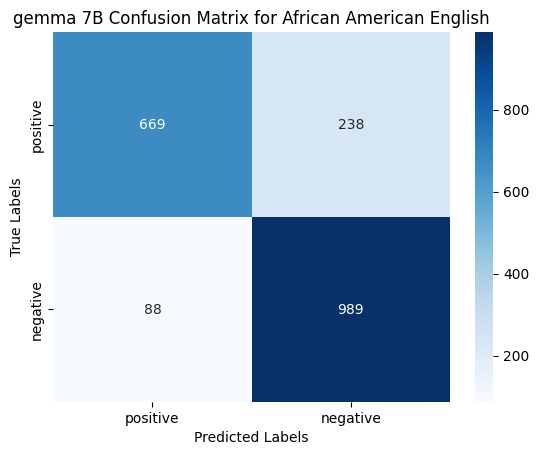

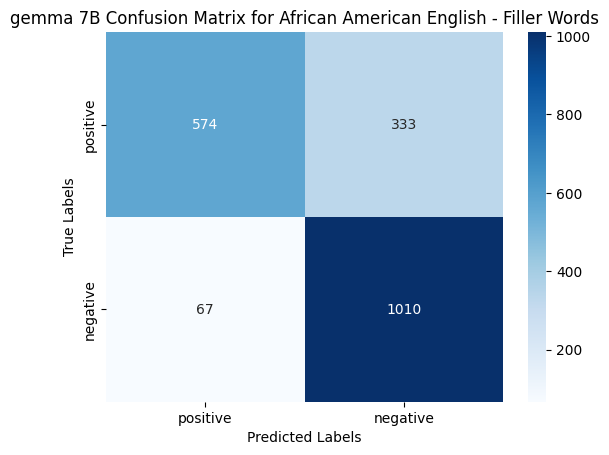

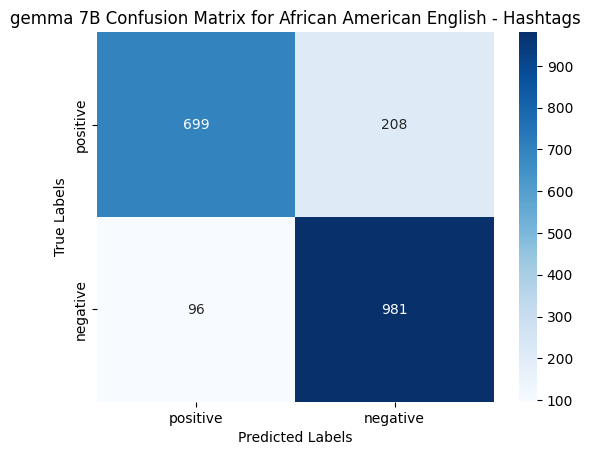

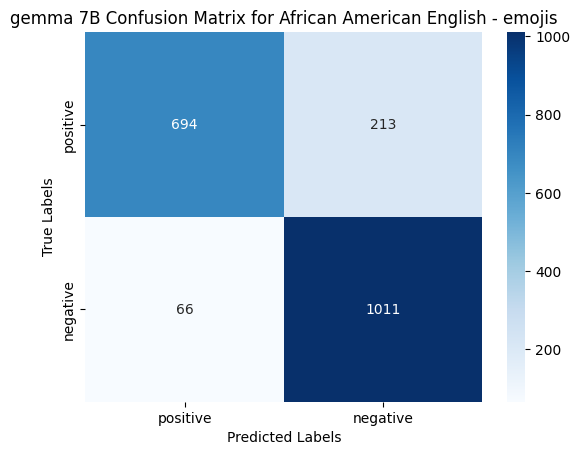

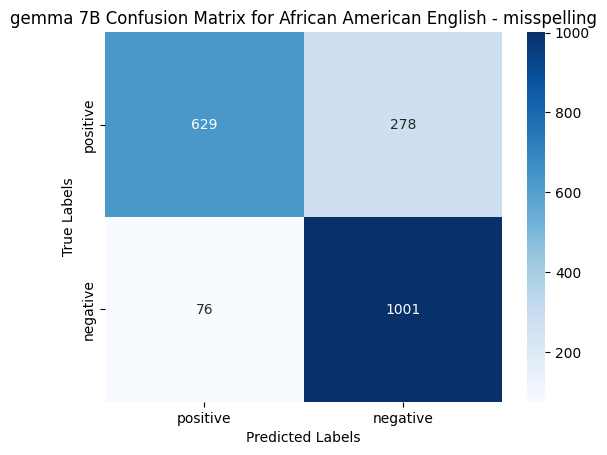

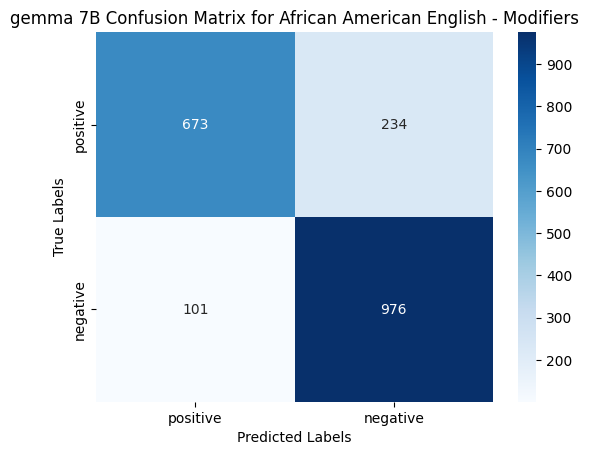

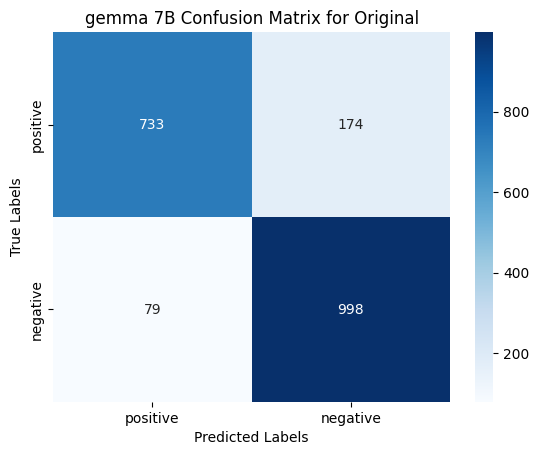

In [76]:
maping = {'AAVE-dataset': 'African American English', 'AAVE-Filler-words-dataset': 'African American English - Filler Words',
         'AAVE-hashtags-words-dataset': 'African American English - Hashtags', 'AAVE-emojis-words-dataset': 'African American English - emojis',
         'AAVE-misspelling-words-dataset': 'African American English - misspelling', 'AAVE-misplaced-dangling-modifiers-dataset': 'African American English - Modifiers',
         'Final-original-dataset':'Original'}

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import json
for models_predictions, model_name in datasets:
    for model_specific_dataset, dataset_name in models_predictions:
        metrics = classification_report(y_true=model_specific_dataset['sentiment'],y_pred=model_specific_dataset['prediction'], output_dict=True)
        cm = confusion_matrix(model_specific_dataset['sentiment'], model_specific_dataset['prediction'], labels=["positive", "negative"])
        #dataframe = dataset.to_pandas() 
        TN, FP, FN, TP = cm.ravel()
        TPR = TP / (TP + FN)
        FPR = FP / (FP + TN)
        FNR = FN / (FN + TP)
        TNR = TN / (TN + FP)
        metrics['TPR'] = TPR
        metrics['FPR'] = FPR
        metrics['TNR'] = TNR
        metrics['FNR'] = FNR
        
        fig, ax = plt.subplots()
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax, xticklabels=["positive", "negative"], yticklabels=["positive", "negative"])
        ax.set_title(f'{model_name} 7B Confusion Matrix for {maping[dataset_name]}')
        ax.set_xlabel('Predicted Labels')
        ax.set_ylabel('True Labels')

        report_json = json.dumps(metrics, indent=4)
        with open(f'./{model_name}/{dataset_name}_classification_report.json', 'w') as file:
            file.write(report_json)
        plt.savefig(f"./{model_name}/plots/{maping[dataset_name]}_CM_plot.png")

In [89]:
import os
import json
def get_folder_names(directory):
    """
    Returns a list of names of all folders in the given directory.

    :param directory: Path to the directory
    :return: List of folder names
    """
    file_names = []
    for entry in os.listdir(directory):
        full_path = os.path.join(directory, entry)
        if (entry[-5:] == '.json'):
            file_names.append(entry)
        #if os.path.isdir(full_path):
            
    return file_names
dir_path = "./gemma/"

# Get the folder names
files = get_folder_names(dir_path)
print(files)

['AAVE-dataset_classification_report.json', 'AAVE-Filler-words-dataset_classification_report.json', 'AAVE-hashtags-words-dataset_classification_report.json', 'AAVE-emojis-words-dataset_classification_report.json', 'AAVE-misspelling-words-dataset_classification_report.json', 'AAVE-misplaced-dangling-modifiers-dataset_classification_report.json', 'Final-original-dataset_classification_report.json']


In [90]:
maping = {'AAVE-dataset': 'African American English', 'AAVE-Filler-words-dataset': 'African American English - Filler Words',
         'AAVE-hashtags-words-dataset': 'African American English - Hashtags', 'AAVE-emojis-words-dataset': 'African American English - emojis',
         'AAVE-misspelling-words-dataset': 'African American English - misspelling', 'AAVE-misplaced-dangling-modifiers-dataset': 'African American English - Modifiers',
         'Final-original-dataset':'Original'}
import pandas as pd
import json

directory = "./gemma/"

# Metrics to plot
metrics = ["TPR", "FPR", "TNR", "FNR"]  # Include more metrics if needed

# Initialize data storage
data = {metric: [] for metric in metrics}

# Assuming 'files' is a list of file names you want to process
# Replace 'files' with the actual list of file names
#files = [...]  # Add your list of files here

# Process each file
for file_name in files:
    # Construct the file path
    file_path = f"{directory}/{file_name}"
    
    # Load the JSON content
    with open(file_path, 'r') as file:
        content = json.load(file)
        
        # Simplify the file name for the plot
        simplified_name = file_name.split('_')[0]
        
        for metric in metrics:
            value = round(content.get(metric, 0), 4)  # Round the metric value
            data[metric].append( value)

# Function to sort the data and prepare for DataFrame
def prepare_data(data):
    sorted_data = {}
    for metric, values in data.items():
        # Sort by name, ensuring 'original_dataset' comes first, and then by value
        sorted_values = sorted(values)
        sorted_data[metric] = [value for name, value in sorted_values]
    return sorted_data

# Prepare and sort the data
#sorted_data = prepare_data(data)

#print(sorted_data)

# Create a DataFrame
df = pd.DataFrame(data)  # Assuming the same order for all metrics

# Save the DataFrame as a CSV file
csv_file_path = f"results_table/gemma_metrics_table.csv"
#df['Augmentation Name'] = [file_name.split('_')[0] for file_name in files]
df.insert(0,'Augmentation Name', [maping[file_name.split('_')[0]] for file_name in files], )
df.to_csv(csv_file_path, index=False)

print(f"Metrics table saved to {csv_file_path}")

Metrics table saved to results_table/gemma_metrics_table.csv
